In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

from analytics.machine_learning.price_prediction_with_fundamentals import utils

In [2]:
dataset = utils.get_dataset()

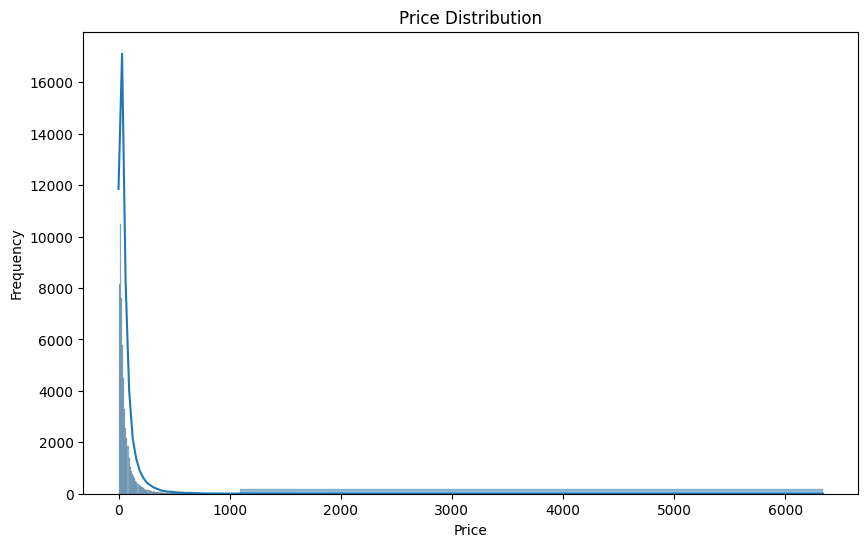

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define your custom bin ranges
zero_to_thousand_step_10 = [
    i * 10 for i in range(110)
]
custom_bins = [*zero_to_thousand_step_10, dataset['price'].max()]

# Create a histogram with custom bins
plt.figure(figsize=(10, 6))
sns.histplot(data=dataset, x='price', bins=custom_bins, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [6]:
dataset['price'].describe()

count    57105.000000
mean        67.289579
std        150.624749
min          0.107500
25%         15.430000
50%         33.755000
75%         71.875000
max       6341.885000
Name: price, dtype: float64

In [3]:
import datetime as dt

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

In [4]:
y_train = train_set[['price', 'sector']]
X_train = train_set.drop(['price'], axis=1)

y_test = test_set[['price', 'sector']]
X_test = test_set.drop(['price'], axis=1)

In [5]:
from sklearn.preprocessing import (
    OneHotEncoder,
)

one_hot_encoder = OneHotEncoder()

X_train_transformed = utils.transform_input(
    X=X_train,
    one_hot_encoder=one_hot_encoder,
    fit=True
)

X_test_transformed = utils.transform_input(
    X=X_test,
    one_hot_encoder=one_hot_encoder,
    fit=False
)

In [16]:
import joblib

# Number of estimators = 100
random_forest_regr = joblib.load('random_forest_regr.sav')

# evaluate model 
y_pred_rf = random_forest_regr.predict(X_test_transformed)

In [9]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regr = RandomForestRegressor(n_estimators=100)

random_forest_regr.fit(X_train_transformed, y_train['price'])

# Make predictions using the testing set
y_pred_rf = pd.Series(random_forest_regr.predict(X_test_transformed))

In [10]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test['price'], y_pred_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test['price'], y_pred_rf))
print("Mean absolute pct error: %.2f" % mean_absolute_percentage_error(y_test['price'], y_pred_rf))

Mean absolute error: 18.35
Coefficient of determination: 0.90
Mean absolute pct error: 0.72


In [8]:
utils.calculate_avg_pct_loss_per_sector(
    y_pred=y_pred_rf,
    y_actual=y_test['price'],
    sector_series=y_test['sector']
)

{'TECHNOLOGY': 32.54268704879244,
 'MANUFACTURING': 30.711455817019658,
 'LIFE SCIENCES': 36.40464011648828,
 'TRADE & SERVICES': 29.74714490921403,
 'FINANCE': 27.47139117874766,
 'ENERGY & TRANSPORTATION': 28.468662080148853,
 'REAL ESTATE & CONSTRUCTION': 23.751855200992235}

In [9]:
utils.calculate_avg_pct_loss_per_price_bucket(
    y_pred=y_pred_rf,
    y_actual=y_test['price'],
    buckets=[
        (0,50),
        (50,100),
        (100,200),
        (200,400),
        (400,600),
        (600, 1000)
    ]
)

{'400 - 600': 39.83016990066644,
 '0 - 50': 34.15036097547034,
 '50 - 100': 20.895870528238806,
 '100 - 200': 24.148268658709036,
 '200 - 400': 24.035328557678646,
 '1000+': 24.290625655601747,
 '600 - 1000': 28.605168921479883}

In [10]:
utils.get_feature_importance_sorted(
    feature_importance_scores=random_forest_regr.feature_importances_,
    feature_names=random_forest_regr.feature_names_in_
)

[('common_stock_shares_outstanding', 0.28877196567917107),
 ('research_and_development', 0.09225133613334029),
 ('treasury_stock', 0.04862095058769071),
 ('profit_loss', 0.04222061705278597),
 ('inventory', 0.034951244747860204),
 ('comprehensive_income_net_of_tax', 0.03244449963824051),
 ('retained_earnings', 0.02636152768656096),
 ('proceeds_from_operating_activities', 0.023580156522672653),
 ('operating_cashflow', 0.016974487926839327),
 ('total_current_assets', 0.01456341031145768),
 ('depreciation_and_amortization', 0.014350104280962946),
 ('current_accounts_payable', 0.013421365908955216),
 ('total_current_liabilities', 0.012911863524421682),
 ('selling_general_and_administrative', 0.01271098538996993),
 ('total_shareholder_equity', 0.012289001909574857),
 ('common_stock', 0.012262883961405069),
 ('depreciation_depletion_and_amortization', 0.011670625431909082),
 ('capital_lease_obligations', 0.010823830489005074),
 ('cash_and_short_term_investments', 0.009457513596784598),
 ('go

## Train random forrest with different hyperparameters

In [15]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regr_v2 = RandomForestRegressor(n_estimators=100, max_depth=10)

random_forest_regr_v2.fit(X_train_transformed, y_train['price'])

# Make predictions using the testing set
y_pred_rf_v2 = pd.Series(random_forest_regr_v2.predict(X_test_transformed))

Mean absolute error: 33.69
Coefficient of determination: 0.82
Mean absolute pct error: 1.46


In [19]:
# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test['price'], y_pred_rf_v2))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test['price'], y_pred_rf_v2))
print("Mean absolute pct error: %.2f" % mean_absolute_percentage_error(y_test['price'], y_pred_rf_v2))

Mean absolute error: 33.69
Coefficient of determination: 0.82
Mean absolute pct error: 1.46


## Train with data from specific sector

In [3]:
dataset = utils.get_dataset(sector='TECHNOLOGY')

import datetime as dt

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

y_train = train_set[['price', 'sector']]
X_train = train_set.drop(['price'], axis=1)

y_test = test_set[['price', 'sector']]
X_test = test_set.drop(['price'], axis=1)

from sklearn.preprocessing import (
    OneHotEncoder,
)

one_hot_encoder = OneHotEncoder()

X_train_transformed = utils.transform_input(
    X=X_train,
    one_hot_encoder=one_hot_encoder,
    fit=True
)

X_test_transformed = utils.transform_input(
    X=X_test,
    one_hot_encoder=one_hot_encoder,
    fit=False
)

In [4]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regr_tech = RandomForestRegressor(n_estimators=100)

random_forest_regr_tech.fit(X_train_transformed, y_train['price'])

# Make predictions using the testing set
y_pred_rf_tech = pd.Series(random_forest_regr_tech.predict(X_test_transformed))


In [5]:
# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test['price'], y_pred_rf_tech))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test['price'], y_pred_rf_tech))
print("Mean absolute pct error: %.2f" % mean_absolute_percentage_error(y_test['price'], y_pred_rf_tech))

Mean absolute error: 18.26
Coefficient of determination: 0.90
Mean absolute pct error: 0.72


## Try to train the model with only a subset of features

### Features decided from CorrelationAnalysis notebook

In [10]:
features_subset = [
    'total_revenue',
    'selling_general_and_administrative',
    'operating_expenses',
    'investment_income_net',
    'interest_expense',
    'non_interest_income',
    'other_non_operating_income',
    'depreciation',
    'income_tax_expense',
    'interest_and_debt_expense',
    'comprehensive_income_net_of_tax',
    'net_income',
    'total_current_assets',
    'cash_and_short_term_investments',
    'current_net_receivables',
    'accumulated_depreciation_amortization_ppe',
    'goodwill',
    'investments',
    'long_term_investments',
    'short_term_investments',
    'other_current_assets',
    'other_non_current_assets',
    'total_liabilities',
    'total_current_liabilities',
    'current_accounts_payable',
    'deferred_revenue',
    'current_debt',
    'short_term_debt',
    'total_non_current_liabilities',
    'capital_lease_obligations',
    'long_term_debt',
    'current_long_term_debt',
    'long_term_debt_noncurrent',
    'other_current_liabilities',
    'other_non_current_liabilities',
    'treasury_stock',
    'retained_earnings',
    'common_stock',
    'common_stock_shares_outstanding',
    'operating_cashflow',
    'proceeds_from_operating_activities',
    'change_in_operating_liabilities',
    'change_in_operating_assets',
    'change_in_receivables',
    'profit_loss',
    'proceeds_from_repayments_of_short_term_debt',
    'payments_for_repurchase_of_preferred_stock',
    'dividend_payout',
    'dividend_payout_preferred_stock',
    'proceeds_from_issuance_of_common_stock',
    'proceeds_from_issuance_of_long_term_debt_and_capital_securities_net',
    'proceeds_from_issuance_of_preferred_stock',
    'proceeds_from_repurchase_of_equity',
    'proceeds_from_sale_of_treasury_stock',
    'change_in_cash_and_cash_equivalents',
    'change_in_exchange_rate',
    'avg_interest_rate',
    'avg_treasury_yield',
    'avg_natural_gas_price',
    'avg_unemployment_rate',
    'inflation',
    'symbol', 
    'reported_currency',
    'fiscal_date_ending',
    'sector',
    'price'
]

In [11]:
dataset = utils.get_dataset()

dataset = dataset[features_subset]

import datetime as dt

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

y_train = train_set[['price', 'sector']]
X_train = train_set.drop(['price'], axis=1)

y_test = test_set[['price', 'sector']]
X_test = test_set.drop(['price'], axis=1)

from sklearn.preprocessing import (
    OneHotEncoder,
)

one_hot_encoder = OneHotEncoder()

X_train_transformed = utils.transform_input(
    X=X_train,
    one_hot_encoder=one_hot_encoder,
    fit=True
)

X_test_transformed = utils.transform_input(
    X=X_test,
    one_hot_encoder=one_hot_encoder,
    fit=False
)

In [12]:
X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53947 entries, 0 to 53946
Data columns (total 68 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   total_revenue                                                        53947 non-null  float64
 1   selling_general_and_administrative                                   53947 non-null  float64
 2   operating_expenses                                                   53947 non-null  float64
 3   investment_income_net                                                53947 non-null  float64
 4   interest_expense                                                     53947 non-null  float64
 5   non_interest_income                                                  53947 non-null  float64
 6   other_non_operating_income                                           53947 non-null  float64
 7   depr

In [13]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regr= RandomForestRegressor(n_estimators=100)

random_forest_regr.fit(X_train_transformed, y_train['price'])

# Make predictions using the testing set
y_pred_rf = pd.Series(random_forest_regr.predict(X_test_transformed))

In [14]:
# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test['price'], y_pred_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test['price'], y_pred_rf))
print("Mean absolute pct error: %.2f" % mean_absolute_percentage_error(y_test['price'], y_pred_rf))

Mean absolute error: 19.25
Coefficient of determination: 0.91
Mean absolute pct error: 0.79


In [15]:
utils.calculate_avg_pct_loss_per_sector(
    y_pred=y_pred_rf,
    y_actual=y_test['price'],
    sector_series=y_test['sector']
)

{'TECHNOLOGY': 34.86406304157199,
 'MANUFACTURING': 32.71657919403849,
 'LIFE SCIENCES': 37.8590692126793,
 'TRADE & SERVICES': 30.782997534568498,
 'FINANCE': 28.071381014665338,
 'ENERGY & TRANSPORTATION': 27.562690071889914,
 'REAL ESTATE & CONSTRUCTION': 24.950181874080798}

## Use subset of features based on Mutual Information notebook

In [6]:
sorted_features = [
    'symbol', 
    'reported_currency',
    'fiscal_date_ending',
    'sector',
    'price',
    'profit_loss',
    'comprehensive_income_net_of_tax',
    'retained_earnings',
    'net_income',
    'income_before_tax',
    'ebit',
    'net_income_from_continuing_operations',
    'gross_profit',
    'total_revenue',
    'operating_income',
    'total_shareholder_equity',
    'ebitda',
    'total_current_assets',
    'non_interest_income',
    'operating_expenses',
    'current_net_receivables',
    'other_non_current_assets',
    'change_in_cash_and_cash_equivalents',
    'income_tax_expense',
    'total_assets',
    'total_current_liabilities',
    'selling_general_and_administrative',
    'payments_for_repurchase_of_common_stock',
    'long_term_debt_noncurrent',
    'payments_for_repurchase_of_equity',
    'total_liabilities',
    'intangible_assets',
    'current_accounts_payable',
    'total_non_current_assets',
    'change_in_operating_liabilities',
    'accumulated_depreciation_amortization_ppe',
    'property_plant_equipment',
    'other_current_liabilities',
    'change_in_operating_assets',
    'proceeds_from_repurchase_of_equity',
    'other_non_current_liabilities',
    'net_interest_income',
    'common_stock',
    'goodwill',
    'total_non_current_liabilities',
    'short_long_term_debt_total',
    'change_in_receivables',
    'interest_and_debt_expense',
    'other_current_assets',
    'depreciation_and_amortization',
    'intangible_assets_excluding_goodwill',
    'depreciation',
    'current_debt',
    'deferred_revenue',
    'investments',
    'interest_expense',
    'other_non_operating_income',
    'cash_and_short_term_investments',
    'cash_and_cash_equivalents_at_carrying_value',
    'cost_of_revenue',
    'operating_cashflow',
    'short_term_debt',
    'payments_for_operating_activities',
    'treasury_stock',
    'long_term_investments',
    'research_and_development',
    'investment_income_net',
    'cost_of_goods_and_services_sold',
    'capital_lease_obligations',
    'dividend_payout_preferred_stock',
    'inventory',
    'cashflow_from_financing',
    'long_term_debt',
    'interest_income',
    'avg_treasury_yield',
    'avg_interest_rate',
    'avg_natural_gas_price',
    'avg_oil_price',
    'proceeds_from_repayments_of_short_term_debt',
    'change_in_exchange_rate',
    'avg_global_commodities_index_value',
    'short_term_investments',
    'cashflow_from_investment',
    'sector_REAL ESTATE & CONSTRUCTION',
    'dividend_payout',
    'dividend_payout_common_stock',
    'avg_unemployment_rate',
    'capital_expenditures',
    'inflation',
    'depreciation_depletion_and_amortization',
    'proceeds_from_issuance_of_long_term_debt_and_capital_securities_net',
    'current_long_term_debt',
    'sector_ENERGY & TRANSPORTATION',
    'change_in_inventory',
    'sector_FINANCE',
    'common_stock_shares_outstanding',
    'proceeds_from_operating_activities',
    'sector_TRADE & SERVICES',
    'proceeds_from_issuance_of_common_stock',
    'sector_TECHNOLOGY',
    'proceeds_from_sale_of_treasury_stock',
    'sector_MANUFACTURING',
    'sector_LIFE SCIENCES',
    'proceeds_from_issuance_of_preferred_stock',
    'payments_for_repurchase_of_preferred_stock',
]

In [7]:
len(sorted_features)

105

In [8]:
dataset = utils.get_dataset()

# Keep only the top 50
dataset = dataset[sorted_features[:55]] # 55 because of symbol, price, fiscal_date_ending, reported_currency

import datetime as dt

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

y_train = train_set[['price', 'sector']]
X_train = train_set.drop(['price'], axis=1)

y_test = test_set[['price', 'sector']]
X_test = test_set.drop(['price'], axis=1)

from sklearn.preprocessing import (
    OneHotEncoder,
)

one_hot_encoder = OneHotEncoder()

X_train_transformed = utils.transform_input(
    X=X_train,
    one_hot_encoder=one_hot_encoder,
    fit=True
)

X_test_transformed = utils.transform_input(
    X=X_test,
    one_hot_encoder=one_hot_encoder,
    fit=False
)

In [9]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regr= RandomForestRegressor(n_estimators=100)

random_forest_regr.fit(X_train_transformed, y_train['price'])

# Make predictions using the testing set
y_pred_rf = pd.Series(random_forest_regr.predict(X_test_transformed))

In [10]:
# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test['price'], y_pred_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test['price'], y_pred_rf))
print("Mean absolute pct error: %.2f" % mean_absolute_percentage_error(y_test['price'], y_pred_rf))

Mean absolute error: 25.76
Coefficient of determination: 0.80
Mean absolute pct error: 1.18
